In [1]:
from src.mopso import *
from src.repository.encoding import RealEncoding
from src.Problems.dtlz import Dtlz
from src.repository.mutation import PolynomialM
from src.repository.selection import BinaryTSMO

In [2]:
def plot_single_view(ax, front, objectives, labels, title):
    x = []
    y = []
    z = []
    for solution in front:
        objective_values = objectives(solution.value)
        x.append(objective_values[0])
        y.append(objective_values[1])
        z.append(objective_values[2])

    ax.scatter(x, y, z, marker='o', label=f'Front {len(front)}')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.set_title(title)
    ax.legend()

def plot_pareto_front_3d(front, objectives, title="Pareto-optimal Front", labels=None, m=3):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    plot_single_view(ax1, front, objectives, labels, title)

    ax2 = fig.add_subplot(132, projection='3d')
    plot_single_view(ax2, front, objectives, labels, title)
    ax2.view_init(elev=20, azim=30)  # Set custom viewing angles

    ax3 = fig.add_subplot(133, projection='3d')
    plot_single_view(ax3, front, objectives, labels, title)
    ax3.view_init(elev=45, azim=-30)  # Set custom viewing angles

    #display(fig)

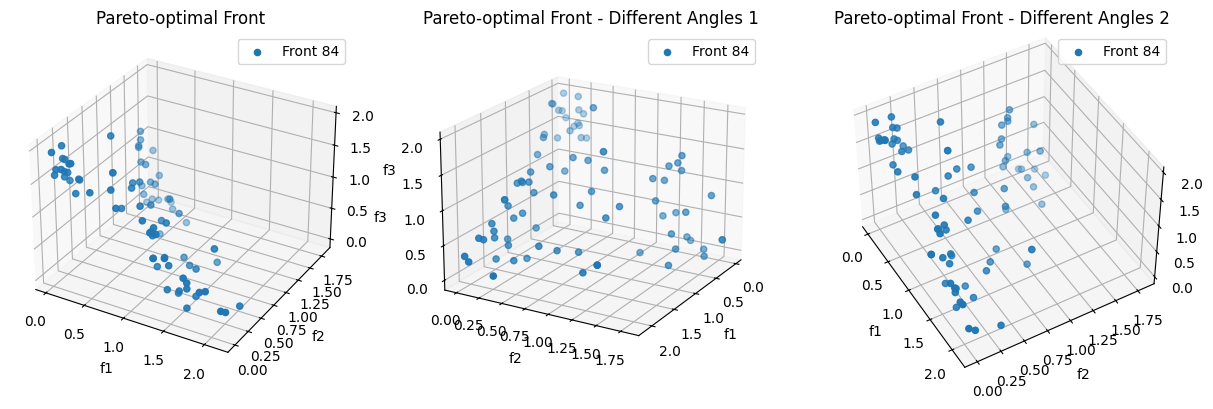

In [3]:
dtlz1 = Dtlz(2)
config = Config(n_var=dtlz1.n,n_iter=100,n_pop=300,c1=0.6,c2=0.4,beta=1,gamma=1,alpha=0.1,w=0.3,n_neighborhoods=10)
mutation = PolynomialM(0.5)
selection = BinaryTSMO()
real_encoding = RealEncoding(bounds=dtlz1.bounds)
pso = MOPSO(encoding=real_encoding,config=config,mutation=mutation,selection=selection)
res = pso.run(dtlz1.evaluate,True)

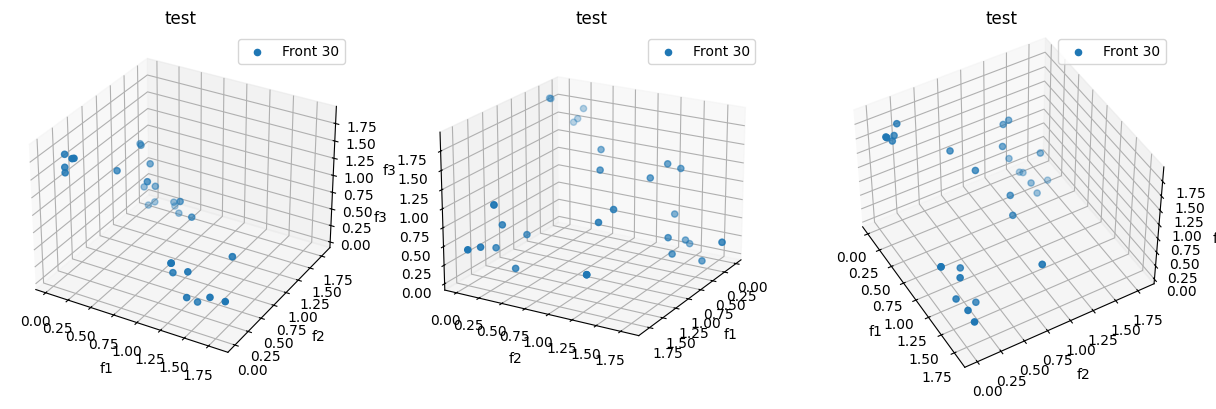

In [4]:
plot_pareto_front_3d(res,dtlz1.evaluate,title='test',labels=['f1','f2','f3'])

In [5]:
''''
n neighbors = len(pop)/50

mean distance neigh

if normalize mean distance of negihbors < treshhold:
    selec best from neighborhood -- closest to median
    delte rest neighborhood
    update 
'''

"'\nn neighbors = len(pop)/50\n\nmean distance neigh\n\nif normalize mean distance of negihbors < treshhold:\n    selec best from neighborhood -- closest to median\n    delte rest neighborhood\n    update \n"